OSE scentific computation final report  WS 2020/2021 Bonn University
Title
author: Po-Tse Cheng

In [1]:
import numpy as np 
import pandas as pd
import math
import time
import seaborn as sns
import matplotlib.pyplot as plt

from tools.auxiliary import*
from tools.GSSA_1_agent import*

What you can expect in this notebook:

- All of the matlab codes from the original authors have been translated into python, including Appendix.
- Besides of the representitive agent model, a multicountry model purposed by the paper is also implemented in python.

What is the caveat:

- The time in general will not match, as python in general is slower than matlab.
- Accuracy will also differs, but in general will not affect our conclusion.
- Two proximation methods included in GSSA, namely LAD-DP and RLAD-DP is not implemented



This notebook contains the python implementation of the General Stochastic Simulation Algorithm (GSSA), developed by Kenneth L. Judde et. al (2011). 

## Introduction

## Generalised simulation stochastic algorithm

### 2.1 The Representitive Agent Model

Consider an agent that faces intertemporal utility-maximisation problem:

\begin{align*}

\max_{\{k_{t+1}, c_{t}\}_{t=0,...,\infty}}&E_{0}\sum^{\infty}_{t=0}\beta^{t}u(c_{t}) \tag{1} \\

s.t.\quad &c_{t}+k_{t+1}=(1-\delta)k_{t}+a_{t}f(k_{t}), \tag{2}\\
&\ln a_{t+1}=\rho\ln a_{t}+\epsilon_{t+1}, \epsilon_{t+1}\sim \mathcal{N}(0,\,\sigma^{2}) \tag{3}\\
&u^{'}(c_{t})=E_{t}\{\beta u^{'}(c_{t+1})[1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \tag{4}
\end{align*}

  Where $u(\boldsymbol{\cdot})$ represents the utility function, $E_{t}$ on the other hand denotes the expectation operator for the information given at time $t$.  $c_{t}$, $k_{t}$, $a_{t}$ stands for consumption, capital, and productivity level respectively. $f(\boldsymbol{\cdot})$ describes the production function. $\beta \in (0,1)$ denotes the discount factor; while $\delta \in (0,1]$ and $\rho \in (-1,1)$ represents depreciation of capital and autocorrelation coefficient of the productivity level. $\sigma \geq 0$ stands for the standard deviation of the productivity shock. Notice that during $t=0$ both $k_{0}$ and $a_{0}$ are given.

  The solution to the stochastic model needs to satisfy the Euler equation (4), while also both transition equations (2) (3). Our objective will be trying to obtain both policy and consumption function, which denotes as $K(\boldsymbol{\cdot})$, $C(\boldsymbol{\cdot})$. Both solutions also need to be able to represent as a Markov equilibrium such that $k_{t+1}= K(k_{t},a_{t})$ and $c_{t}=C(k_{t}, a_{t})$.

  So how do we solve this problem? We will be using 2 particular tools to obtain our solutions. Firstly, we will incorporate the flexible functional form $\psi(\boldsymbol{\cdot} ;b)$ purposed by Marcelt et. al (1988) to approximate the original policy function $K(\boldsymbol{\cdot})$. Here $b$ denotes the vector of coefficients that we wish to obtain. A key difference between Judd et.al (2011) and Marcelt et. al (1988) is that instead of incorporating the original exponential $\psi$:

\begin{align*}
\psi(k_{t}, a_{t}; b)= \exp (b_{0}+ b_{1} \ln a_{t}+,...,b_{n} \ln (a_{t})^{l}) 
\end{align*}

  They change the flexible functional form to the following:

\begin{align*}
\psi(k_{t}, a_{t}; b)=  b_{0}+ b_{1} \ln a_{t}+,...,b_{n} \ln (a_{t})^{l}
\end{align*}

  The motivation behind this attempt is to further reduce the complexity of obtaining $b$ by allow linear regression methods instead of non-linear ones. Therefore we will be approximating $K(\boldsymbol{\cdot})$ with:

\begin{align*}
b_{0}+ b_{1} \ln a_{t}+,...,b_{n} \ln (a_{t})^{l} =\psi(k_{t}, a_{t}; b) \approx K(k_{t},a_{t})=k_{t+1} \tag{5}
\end{align*}

  We will now consider the second tool: Fixed point construction. We can do so by rewriting equation (4) as follow:

\begin{align*}
&u^{'}(c_{t})=E_{t}\{\beta u^{'}(c_{t+1})[1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \\
&\equiv  1=E_{t}\{\beta\frac{u^{'}(c_{t+1})}{u^{'}(c_{t})} [1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \\
&\equiv k_{t+1}= E_{t}\{\beta\frac{u^{'}(c_{t+1})}{u^{'}(c_{t})} [1-\delta+a_{t+1}f^{'}(k_{t+1})]k_{t+1}\} \tag{6}
\end{align*}

  Given that the first derivative of utility function $u^{'}(c_{t})$ in the Euler equation can never be 0, equation (6) holds under any condition. By combining both equation (5) and equation (6) (by subtitution), we will be able to solve the stochastic model by computing the conditional expectation.

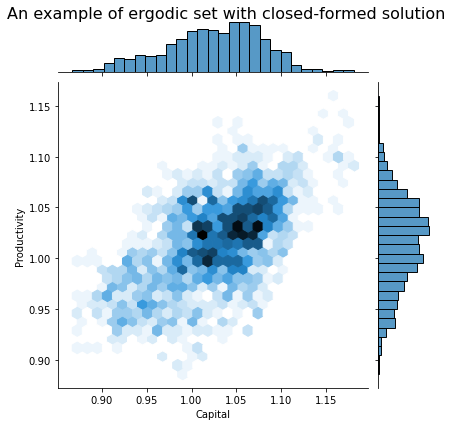

In [2]:
Figure1()

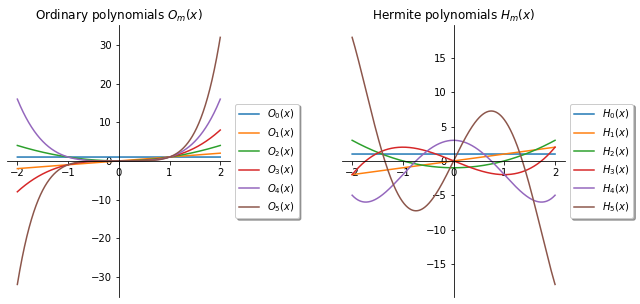

In [3]:
Figure2()

In [4]:
showcase_result = GSSA_ShowcaseResult()

In [5]:
showcase_result

,Maximum Error,Mean Error,Time,Error Time,Polynomial Degree,Total Time,Rounded Total Time,Original Mean Error,Original Max Error
0,-3.366134,-4.358702,31.858807,1.047193,1,32.906000,32.91,4.378225e-05,4.303938e-04
1,-4.883611,-6.118154,49.818780,0.928832,2,50.747612,50.75,7.618090e-07,1.307343e-05
2,-5.951989,-7.481158,74.320316,0.934037,3,75.254353,75.25,3.302497e-08,1.116891e-06
3,-7.021109,-8.716908,100.602536,1.203135,4,101.805671,101.81,1.919073e-09,9.525560e-08
4,-7.178648,-8.893002,143.971520,1.181395,5,145.152915,145.15,1.279377e-09,6.627529e-08


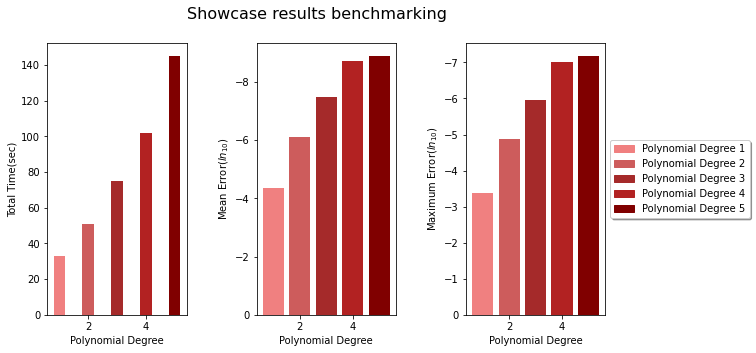

In [6]:
Figure3(showcase_result)

<AxesSubplot:label='cb9238cb-7350-4b39-ba78-2d4894a9168e', xlabel='Rounded Total Time', ylabel='Mean Error'>

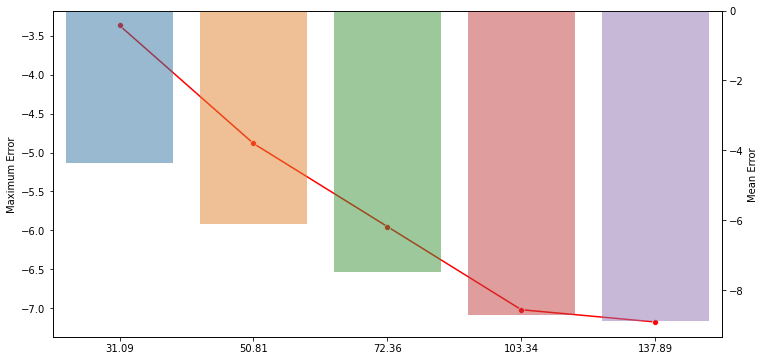

In [7]:
#save it for the big table
#plot with regards to time, maxi for visualisation
# will be added to auxiliary
# add title and so on
#ax1 = sns.set_style(style=None, rc=None )

#fig, ax1 = plt.subplots(figsize=(12,6))

#sns.lineplot(data = showcase_result["Maximum Error"], marker='o', ax=ax1, color='r')
#ax2 = ax1.twinx()

#sns.barplot(data = showcase_result, x="Rounded Total Time", y="Mean Error", alpha=0.5, ax=ax2)

In [4]:
# IM = one node MC only
# RM = OLS
# without normalisation
max_1_0, mean_1_0, error_time_1_0, Time_1_0, stage1_time_1_0 = GSSA_1_agent(D_max=2, IM=0, RM=1 ,normalize=0, penalty=3, PF=0)

# The stability cannot be achieve with polynominal degree higher than 2
mean_1_0.append([0,0,0])
Time_1_0.append([0,0,0])
max_1_0.append([0,0,0])

# IM = one node MC only
# RM = OLS
# with normalisation
max_1_1, mean_1_1, error_time_1_1, Time_1_1, stage1_time_1_1 = GSSA_1_agent(D_max=3, IM=0, RM=1,normalize=1, penalty=3, PF=0)

# The stability cannot be achieve with polynominal degree higher than 3
mean_1_1.append([0,0])
Time_1_1.append([0,0])
max_1_1.append([0,0])

# IM = one node MC only
# RM = OLS
# without normalisation with hermite
max_1_2, mean_1_2, error_time_1_2, Time_1_2, stage1_time_1_2 = GSSA_1_agent(D_max=5, IM=0, RM=1 ,normalize=0, penalty=3, PF=1)

# IM = one node MC only
# RM = RLS-Tikhonov
# Smaller regulation k = -7
max_5_0, mean_5_0, error_time_5_0, Time_5_0, stage1_time_5_0 = GSSA_1_agent(D_max=5, IM=5, RM=6 ,normalize=1, penalty=-10, PF=0)

# IM = one node MC only
# RM = RLS-Tikhonov
# Larger regulation k = -4
max_5_1, mean_5_1, error_time_5_1, Time_5_1, stage1_time_5_1 = GSSA_1_agent(D_max=5, IM=0, RM=6 ,normalize=1, penalty=-7, PF=0)

#Dataframe row 1
df_0 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_1_0,
"Max Error":max_1_0,
"Total Time":[Time_1_0[i]+stage1_time_1_0+error_time_1_0 for i in range(5)],
"Method": "Unnormalised OLS"
})

df_1 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_1_1,
"Max Error":max_1_1,
"Total Time":[Time_1_1[i]+stage1_time_1_1+error_time_1_1 for i in range(5)],
"Method": "Normalised OLS"
})

df_2 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_1_2,
"Max Error":max_1_2,
"Total Time":[Time_1_2[i]+stage1_time_1_2+error_time_1_2 for i in range(5)],
"Method": "Hermite OLS"
})
df_3 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_5_0,
"Max Error":max_5_0,
"Total Time":[Time_5_0[i]+stage1_time_5_0+error_time_5_0 for i in range(5)],
"Method": "Smaller Regulation RLS-Tikhonov"
})

df_4 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_5_1,
"Max Error":max_5_1,
"Total Time":[Time_5_1[i]+stage1_time_5_1+error_time_5_1 for i in range(5)],
"Method": "Larger Regulation RLS-Tikhonov"
})

result1 = pd.concat([df_0, df_1, df_2, df_3, df_4])

KeyboardInterrupt: 

In [ ]:
# IM = one node MC only
# RM = LS-SVD
# without normalisation
max_2_0, mean_2_0, error_time_2_0, Time_2_0, stage1_time_2_0 = GSSA_1_agent(D_max=4, IM=0, RM=2 ,normalize=0, penalty=3, PF=0)

# The stability cannot be achieve with polynominal degree higher than 4
mean_2_0.append(0)
Time_2_0.append(0)
max_2_0.append(0)

# IM = one node MC only
# RM = LS-SVD
# with normalisation
max_2_1, mean_2_1, error_time_2_1, Time_2_1, stage1_time_2_1 = GSSA_1_agent(D_max=5, IM=0, RM=2,normalize=1, penalty=3, PF=0)

# IM = one node MC only
# RM = LS-SVD
# without normalisation with hermite
max_2_2, mean_2_2, error_time_2_2, Time_2_2, stage1_time_2_2 = GSSA_1_agent(D_max=5, IM=0, RM=2 ,normalize=0, penalty=3, PF=1)

# Notice it doesnt matter after RM=4 if the data is normalised or not, it will get normalised as long as RM >=5



# IM = one node MC only
# RM = RLS-TSVD
# Smaller regulation k = 8
max_6_0, mean_6_0, error_time_6_0, Time_6_0, stage1_time_6_0 = GSSA_1_agent(D_max=5, IM=0, RM=6 ,normalize=1, penalty=8, PF=0)

# IM = one node MC only
# RM = RLS-TSVD
# Larger regulation k = 6
max_6_1, mean_6_1, error_time_6_1, Time_6_1, stage1_time_6_1 = GSSA_1_agent(D_max=5, IM=0, RM=6 ,normalize=1, penalty=6, PF=0)

# IM = one node MC only
# RM = RLS-TSVD
# Hermite
#max_6_2, mean_6_2, error_time_6_2, Time_6_2, stage1_time_6_2 = GSSA_1_agent(D_max=5, IM=0, RM=6,normalize=1, penalty=7, PF=1)

#Dataframe row 2
df_0 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_2_0,
"Max Error":max_2_0,
"Total Time":[Time_2_0[i]+stage1_time_2_0+error_time_2_0 for i in range(5)],
"Method": "Unnormalised LS-SVD"
})

df_1 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_2_1,
"Max Error":max_2_1,
"Total Time":[Time_2_1[i]+stage1_time_2_1+error_time_2_1 for i in range(5)],
"Method": "Normalised LS-SVD"
})

df_2 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_2_2,
"Max Error":max_2_2,
"Total Time":[Time_2_2[i]+stage1_time_2_1+error_time_2_1 for i in range(5)],
"Method": "Hermite LS-SVD"
})
df_3 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_6_0,
"Max Error":max_6_0,
"Total Time":[Time_6_0[i]+stage1_time_6_0+error_time_6_0 for i in range(5)],
"Method": "Smaller Regulation RLS"
})

df_4 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_6_1,
"Max Error":max_6_1,
"Total Time":[Time_6_1[i]+stage1_time_6_1+error_time_6_1 for i in range(5)],
"Method": "Larger Regulation RLS-TSVD"
})

result2 = pd.concat([df_0, df_1, df_2, df_3, df_4])

# Make sure the time for unnormalised LS-SVD is not considered
result2.iloc[4,3]= 0


In [ ]:
# IM = one node MC only
# RM = LAD-PP
# without normalisation
max_3_0, mean_3_0, error_time_3_0, Time_3_0, stage1_time_3_0 = GSSA_1_agent(D_max=4, IM=0, RM=3,normalize=0, penalty=3, PF=0)

# The stability cannot be achieve with polynominal degree higher than 4
mean_3_0.append(0)
Time_3_0.append(0)
max_3_0.append(0)

# IM = one node MC only
# RM = LAD-PP
# with normalisation
max_3_1, mean_3_1, error_time_3_1, Time_3_1, stage1_time_3_1 = GSSA_1_agent(D_max=5, IM=0, RM=3,normalize=1, penalty=3, PF=0)

# IM = one node MC only
# RM = LAD-PP
# without normalisation with hermite
max_3_2, mean_3_2, error_time_3_2, Time_3_2, stage1_time_3_2 = GSSA_1_agent(D_max=5, IM=0, RM=3,normalize=0, penalty=3, PF=1)


# IM = one node MC only
# RM = RLAD-PP
# Smaller regulation k = -6
max_7_0, mean_7_0, error_time_7_0, Time_7_0, stage1_time_7_0 = GSSA_1_agent(D_max=5, IM=0, RM=7,normalize=1, penalty=-6, PF=0)

# IM = one node MC only
# RM = RLAD-PP
# Larger regulation k = -4
max_7_1, mean_7_1, error_time_7_1, Time_7_1, stage1_time_7_1 = GSSA_1_agent(D_max=5, IM=0, RM=7,normalize=1, penalty=-4, PF=0)



#Dataframe row 2
df_0 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_3_0,
"Max Error":max_3_0,
"Total Time":[Time_3_0[i]+stage1_time_3_0+error_time_3_0 for i in range(5)],
"Method": "Unnormalised LAD-PP"
})

df_1 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_3_1,
"Max Error":max_3_1,
"Total Time":[Time_3_1[i]+stage1_time_3_1+error_time_3_1 for i in range(5)],
"Method": "Normalised LAD-PP"
})

df_2 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_3_2,
"Max Error":max_3_2,
"Total Time":[Time_3_2[i]+stage1_time_3_1+error_time_3_1 for i in range(5)],
"Method": "Hermite LAD-PP"
})
df_3 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_7_0,
"Max Error":max_7_0,
"Total Time":[Time_7_0[i]+stage1_time_7_0+error_time_7_0 for i in range(5)],
"Method": "Smaller Regulation RLAD-PP"
})

df_4 = pd.DataFrame({"Polynomial Degree":[i for i in range(1,6)],
"Mean Error":mean_7_1,
"Max Error":max_7_1,
"Total Time":[Time_7_1[i]+stage1_time_7_1+error_time_7_1 for i in range(5)],
"Method": "Larger Regulation RLAD-PP"
})

result3 = pd.concat([df_0, df_1, df_2, df_3, df_4])

# Make sure the time for unnormalised LS-SVD is not considered



In [ ]:
sns.factorplot(x='Polynomial Degree', y='Total Time', hue='Method', data=result1, kind='bar')

In [ ]:
sns.factorplot(x='Polynomial Degree', y='Total Time', hue='Method', data=result2, kind='bar')

In [ ]:
sns.factorplot(x='Polynomial Degree', y='Total Time', hue='Method', data=result3, kind='bar')

In [ ]:
sns.factorplot(x='Polynomial Degree', y='Max Error', hue='Method', data=result2, kind='bar')

In [ ]:
sns.factorplot(x='Polynomial Degree', y='Max Error', hue='Method', data=result1, kind='bar')

In [15]:
df = pd.DataFrame({'LSV_un':mean_2_0,
'LSV_n':mean_2_1,
'LSV_h':mean_2_2,
'RLSV_small':mean_6_0,
'RLSV_large':mean_6,
"RLSV_h_small":mean_6_2,
})

In [16]:
#monte carol sucks showing

In [3]:


#Table 2_1
max_table2_1 = []
mean_table2_1 = []
error_time_table2_1 = []
Time_table2_1 = []
stage1_time_tables2_1 =[]
for i in range(11):
    max_out, mean_out, error_time, Time_out, stage1_time = GSSA_1_agent(T=3000, T_test=10000, D_max=5, IM=10, RM=6 ,normalize=1, penalty=7, PF=0)
    max_table2_1.append(max_out)
    mean_table2_1.append(mean_out)
    error_time_table2_1.append(error_time)
    Time_table2_1.append(Time_out)
    stage1_time_tables2_1.append(stage1_time)


KeyboardInterrupt: 

In [ ]:
#table_2_2
#T = 10,000


max_table2_2 = []
mean_table2_2 = []
error_time_table2_2 = []
Time_table2_2 = []
stage1_time_tables2_2 =[]
for i in range(11):
    max_out, mean_out, error_time, Time_out, stage1_time = GSSA_1_agent(T=10000, T_test=10200, D_max=5, IM=10, RM=6 ,normalize=1, penalty=7, PF=0)
    max_table2_2.append(max_out)
    mean_table2_2.append(mean_out)
    error_time_table2_2.append(error_time)
    Time_table2_2.append(Time_out)
    stage1_time_tables2_2.append(stage1_time)
